# Signals Analysis

In [5]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import threading
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
import matplotlib_venn
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
from sklearn import preprocessing
import time
import scipy
from sklearn.cross_validation import cross_val_score
from sklearn import tree

sns.set_context('notebook')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
workingDirectory = '/home/jtao/analysis/signals_analysis/'
os.chdir(workingDirectory)

## Functions

In [7]:
def convert_sequences_to_array(sequences):
    '''
    inputs: sequence of nucleotides represented as a string composed of A, C, G, T
    outputs: a list of numpy array representations of a sequence with:
             A = [1, 0, 0, 0]
             C = [0, 1, 0, 0]
             G = [0, 0, 1, 0]
             T = [0, 0, 0, 1]
             
    '''
    nucleotide_array_dict = {'A': [1, 0, 0, 0],
                             'C': [0, 1, 0, 0],
                             'G': [0, 0, 1, 0],
                             'T': [0, 0, 0, 1],
                             'N': [0, 0, 0, 0]}
    sequence_array_list = []
    for seq in sequences:
        seq_array = []
        for nuc in seq:
            seq_array.append(nucleotide_array_dict[nuc])
        seq_array = np.array(seq_array)
        sequence_array_list.append(seq_array)
    return sequence_array_list




In [8]:
def read_fasta(file_path):
    '''
    reads in a fasta file and returns a list of sequence ids and a list of sequences
    inputs: filepath - path to a fasta file
    outputs: sequence_list - a list of sequences
             id_list - a list of ids
    '''
    with open(file_path) as f:
        data = f.readlines()
    id_list = []
    sequence_list = []
    # loop through each sequence
    for line in data:
        if '>' in line:
            seq_id = line.strip()[1:]
            id_list.append(seq_id)
        else:
            seq = line.strip()
            sequence_list.append(seq)
    return sequence_list, id_list



In [9]:
def read_motif_file(motifPath, pseudocount):
    '''
    reads all motif files in a directory 
    inputs: path to a directory containing homer motif files
    outputs: an array of tuples representing each motif
    '''
    name_metadata_dict = {}
    with open(motifPath) as f:
        data = f.readlines()
    name = '.'.join(motifPath.split('/')[-1].split('.')[:-1])
    matrix = []
    metadata = data[0].strip()
    for line in data[1:]:
        tokens = line.strip().split("\t")
        if len(tokens) > 1:
            scores = np.array([float(x) for x in tokens])
            scores = scores + pseudocount
            scores= scores/np.sum(scores)
            matrix.append(scores)
    return (name,np.array(matrix))

In [10]:
def plot_motif_sequence(seq_index,
                        sequence_array_list, 
                        motif_score_dict, 
                        motif_score_rc_dict, 
                        motif_size_dict,
                        threshold = 0,
                        color_dict = None,
                        symmetric_motifs = [],
                        algorithm_plot = False,
                       ):
    '''
    visualize a single sequence using the highest scoring nonoverlapping motifs
    '''
    motif_names = sorted(motif_score_dict.keys())
    seq_array = sequence_array_list[seq_index]
    seq_size = seq_array.shape[0]
    # initialize position_node array
    position_node_array = [[] for x in range(seq_size)]

    # intialize graph
    seq_graph = nx.Graph()

    # initialize
    for motif in motif_names:
        motif_size = motif_size_dict[motif]
        indices = list(range(len(motif_score_dict[motif][seq_index])))
        forward_scores = motif_score_dict[motif][seq_index]
        revcomp_scores = motif_score_rc_dict[motif][seq_index]

        # identify motif instances using score threshold
        filtered_forward_motif_instances = [x for x in zip(indices, forward_scores) if x[1]>threshold]
        filtered_revcomp_motif_instances = [x for x in zip(indices, revcomp_scores) if x[1]>threshold]

        # create graph node for every forward motif instance
        for mi in filtered_forward_motif_instances:
            node_id = str(mi[0]) + '_' + motif
            seq_graph.add_node(node_id, 
                               name=motif,
                               start=mi[0], 
                               end = mi[0] + motif_size, 
                               score=mi[1], 
                               orientation='+')

            # figure out positions motif instance occupies
            start_position = mi[0]
            end_position=start_position + motif_size

            # add node_id to position_node array
            for pos in range(start_position, end_position):
                position_node_array[pos].append(node_id)

        # create graph node for every revcomp motif instance
        for mi in filtered_revcomp_motif_instances:
            node_id = str(mi[0]) + '_' + motif
            seq_graph.add_node(node_id, 
                               name=motif,
                               start=mi[0], 
                               end = mi[0] + motif_size, 
                               score=mi[1], 
                               orientation='-')

            # figure out positions motif instance occupies
            start_position = mi[0]
            end_position=start_position + motif_size

            # add node_id to position_node array
            for pos in range(start_position, end_position):
                position_node_array[pos].append(node_id)

    # figure out which edges to create
    edges_to_add = set()
    for pos in range(len(position_node_array)):
        nodes_at_pos = position_node_array[pos]
        # make sure edges are ordered alphabetically
        # so I don't have to deal with A-B and B-A
        nodes_at_pos.sort() 
        # generate proposed edges
        num_nodes = len(nodes_at_pos)
        for i in range(num_nodes - 1):
            for j in range(i+1, num_nodes):
                id_1 = nodes_at_pos[i]
                id_2 = nodes_at_pos[j]
                edges_to_add.add((id_1,id_2))
    seq_graph.add_edges_from(edges_to_add)

    # find best motif instances

    # loop through nodes and remove motif instances until there are no neighboring motif instances
    num_edges = seq_graph.number_of_edges()
    num_nodes = seq_graph.number_of_nodes()
    
    node_counts = [num_nodes]
    edge_counts = [num_edges]
    motif_instances =[]
    while num_edges > 0:
        # sort nodes by motif score
        sorted_nodes = sorted(seq_graph.nodes(data=True), key=lambda x: x[1]['score'], reverse=True)

        top_node = sorted_nodes[0]
        top_node_id = top_node[0]

        # save motif instance
        motif_instances.append(top_node)

        # remove node and neighbors from graph
        neighbors = seq_graph.neighbors(top_node_id)

        seq_graph.remove_node(top_node_id)
        seq_graph.remove_nodes_from(neighbors)

        num_edges = seq_graph.number_of_edges()
        num_nodes = seq_graph.number_of_nodes()

        node_counts.append(num_nodes)
        edge_counts.append(num_edges)
        
#         print(num_edges, num_nodes)
        
    # create list representation of motifs
    sorted_motif_instances = sorted(motif_instances, key = lambda x:x[1]['start'])
   
    if algorithm_plot:
        with sns.axes_style('ticks'):
            fig, ax1 = plt.subplots()
            ax2 = ax1.twinx()
            ln1 = ax1.plot(list(range(len(node_counts))), 
                     node_counts, 
                     c='red',
                     label = 'Motif Instances')

            ln2 = ax2.plot(list(range(len(edge_counts))), 
                     edge_counts, 
                     c='blue',
                     label = 'Motif Overlaps')
        
            ax1.set_xlabel('# Motifs Selected')
            ax1.set_ylabel('# Motif Instances')
            ax2.set_ylabel('# Motif Overlaps')
            
            lns = ln1+ln2
            labs = [l.get_label() for l in lns]
            ax2.legend(lns, labs, loc=0)
            
    # visualize loci
    if color_dict == None:
        color_dict = dict(zip(motif_names,
                            sns.color_palette("hls", len(motif_names))
                            )
                        )
    with sns.axes_style('ticks'):
        plt.figure(figsize=(16,2))
        for mi in sorted_motif_instances:
            name = mi[1]['name']
            start = mi[1]['start']
            end = mi[1]['end']
            score = mi[1]['score']
            orientation = mi[1]['orientation']

            midpoint = start + (end - start)/2

            color = color_dict[name]
            # plot positions
            if name in symmetric_motifs:
                plt.plot([start, end], [0,0], c=color)
            elif orientation == '+':
                plt.arrow(start, 0, end-start, 0, 
                          color=color, 
                          width=0.1, 
                          head_width=1,
                          length_includes_head=True)
            else:
                plt.arrow(end, 0, start-end, 0, 
                          color=color, 
                          width=0.1, 
                          head_width=1,
                          length_includes_head=True)
    #         plt.plot([start, end], [-1,-1], c=color)
            # plot motif score
            plt.plot([midpoint, midpoint], [0, score], c=color)
            plt.annotate(xy=(midpoint-3.75, 1.5), s=name, size=8, rotation =90, ha='left', va='bottom')
        plt.ylim(-1,14)
        plt.xlim(0,seq_size)
        plt.xlabel('Position')
        plt.ylabel('Motif Score')
        sns.despine()
    
    
    return sorted_motif_instances

In [11]:
def calc_motif_sequence(seq_index,
                        sequence_array_list, 
                        motif_score_dict, 
                        motif_score_rc_dict, 
                        motif_size_dict,
                        threshold = 0,
                        symmetric_motifs = [],
                       ):
    '''
    visualize a single sequence using the highest scoring nonoverlapping motifs
    '''
    motif_names = sorted(motif_score_dict.keys())
    seq_array = sequence_array_list[seq_index]
    seq_size = seq_array.shape[0]
    # initialize position_node array
    position_node_array = [[] for x in range(seq_size)]

    # intialize graph
    seq_graph = nx.Graph()

    # initialize
    for motif in motif_names:
        motif_size = motif_size_dict[motif]
        indices = list(range(len(motif_score_dict[motif][seq_index])))
        forward_scores = motif_score_dict[motif][seq_index]
        revcomp_scores = motif_score_rc_dict[motif][seq_index]

        # identify motif instances using score threshold
        filtered_forward_motif_instances = [x for x in zip(indices, forward_scores) if x[1]>threshold]
        filtered_revcomp_motif_instances = [x for x in zip(indices, revcomp_scores) if x[1]>threshold]

        # create graph node for every forward motif instance
        for mi in filtered_forward_motif_instances:
            node_id = str(mi[0]) + '_' + motif
            seq_graph.add_node(node_id, 
                               name=motif,
                               start=mi[0], 
                               end = mi[0] + motif_size, 
                               score=mi[1], 
                               orientation='+')

            # figure out positions motif instance occupies
            start_position = mi[0]
            end_position=start_position + motif_size

            # add node_id to position_node array
            for pos in range(start_position, end_position):
                position_node_array[pos].append(node_id)

        # create graph node for every revcomp motif instance
        for mi in filtered_revcomp_motif_instances:
            node_id = str(mi[0]) + '_' + motif
            seq_graph.add_node(node_id, 
                               name=motif,
                               start=mi[0], 
                               end = mi[0] + motif_size, 
                               score=mi[1], 
                               orientation='-')

            # figure out positions motif instance occupies
            start_position = mi[0]
            end_position=start_position + motif_size

            # add node_id to position_node array
            for pos in range(start_position, end_position):
                position_node_array[pos].append(node_id)

    # figure out which edges to create
    edges_to_add = set()
    for pos in range(len(position_node_array)):
        nodes_at_pos = position_node_array[pos]
        # make sure edges are ordered alphabetically
        # so I don't have to deal with A-B and B-A
        nodes_at_pos.sort() 
        # generate proposed edges
        num_nodes = len(nodes_at_pos)
        for i in range(num_nodes - 1):
            for j in range(i+1, num_nodes):
                id_1 = nodes_at_pos[i]
                id_2 = nodes_at_pos[j]
                edges_to_add.add((id_1,id_2))
    seq_graph.add_edges_from(edges_to_add)

    # find best motif instances

    # loop through nodes and remove motif instances until there are no neighboring motif instances
    num_edges = seq_graph.number_of_edges()
    num_nodes = seq_graph.number_of_nodes()
    
    node_counts = [num_nodes]
    edge_counts = [num_edges]
    motif_instances =[]
    while num_edges > 0:
        # sort nodes by motif score
        sorted_nodes = sorted(seq_graph.nodes(data=True), key=lambda x: x[1]['score'], reverse=True)

        top_node = sorted_nodes[0]
        top_node_id = top_node[0]

        # save motif instance
        motif_to_save = top_node[1]
        if motif_to_save['name'] in symmetric_motifs:
            motif_to_save['orientation'] = '|'
        motif_instances.append(motif_to_save)

        # remove node and neighbors from graph
        neighbors = seq_graph.neighbors(top_node_id)

        seq_graph.remove_node(top_node_id)
        seq_graph.remove_nodes_from(neighbors)

        num_edges = seq_graph.number_of_edges()
        num_nodes = seq_graph.number_of_nodes()

        node_counts.append(num_nodes)
        edge_counts.append(num_edges)
        
       
    # create list representation of motifs
    sorted_motif_instances = sorted(motif_instances, key = lambda x:x['start'])
   
    
    
    return sorted_motif_instances

In [12]:
def project_database(prefix, database):
    '''
    projects a database of sequences and their corresponding motif paths
    according to a prefix. 
    input: prefix - a string representing a motif and its orientation,
           database - a dictionary containing lists of motif paths
                      corresponding to each sequence
                      {seq_id:[motif_sequences...]}
    output: returns the projected database
    '''
    projected_database = {}
    for seq_id in database:
        projected_paths = []
        motif_paths = database[seq_id]
        for path in motif_paths:
            if prefix in path:
                ind = path.index(prefix)
                proj_path = path[ind+1:]
                if len(proj_path) > 0:
                    projected_paths.append(proj_path)
#         print(prefix, (motif_paths), projected_paths)
        if len(projected_paths) > 0:
            projected_database[seq_id] = projected_paths
        
    return projected_database

In [13]:
def find_frequent_motifs(database, support_level):
    '''
    Finds motifs in database that exceeds support level. 
    For each sequence, collapses the counts of all motif paths corresponding to that sequence
    
    inputs: database - a dictionary containing lists of motif paths
                      corresponding to each sequence
            support_level - number of times a motif must appear to be counted
    outputs: 
    '''
    motif_count_dict = {}
    
    for seq_id in database:
        motifs_in_seq = set()
        motif_paths = database[seq_id]
        for path in motif_paths:
            for motif in path:
                motifs_in_seq.add(motif)
        for m in motifs_in_seq:
            if m in motif_count_dict:
                motif_count_dict[m] += 1
            else:
                motif_count_dict[m] = 1
    
    frequent_motifs = [(x, motif_count_dict[x]) for x in motif_count_dict if motif_count_dict[x] >= support_level]
    sorted_frequent_motifs = sorted(frequent_motifs, key = lambda x:x[1], reverse=True)
    to_return = [x[0] for x in sorted_frequent_motifs]
#     print(len(database), sorted_frequent_motifs[:10])
    return to_return

In [14]:
def motif_prefix_span(prefix, database, support_level):
    '''
    Finds frequents sequences of motifs in a datase of sequences and their corresponding
    motif paths
    inputs: prefix - a string representing a motif and its orientation
            database - a dictionary containing lists of motif paths corresponding to each sequence
            support level - number of times a motif must appear to be counted
    outputs: a list of frequent patterns
    '''
#     print('***', prefix, len(database))
    if len(database) >= support_level:
        frequent_motifs = find_frequent_motifs(database, support_level)
    else:
        frequent_motifs = []
    to_return = []
    if len(frequent_motifs) > 0:
        for fm in frequent_motifs:
            new_pattern = prefix + [fm]
            projected_database = project_database(fm, database)
            
            fm_results = motif_prefix_span(new_pattern, 
                                           projected_database, 
                                           support_level)
            to_return = to_return +  fm_results 

            to_return.append(new_pattern)
    return to_return

In [15]:
def create_pattern_sequence_table(frequent_patterns, database):
    '''
    Constructs a matrix summarizing which sequences contains a frequent motif pattern
    '''
    sorted_ids = sorted(database.keys())
    pattern_names = [' * '.join(x) for x in frequent_patterns]
    sequence_pattern_table = pd.DataFrame(np.zeros((len(sorted_ids), len(pattern_names))),
                                          index = sorted_ids,
                                          columns = pattern_names)
    for i in range(len(frequent_patterns)):
        if i % 10 == 0:
            print(i)
        pattern = frequent_patterns[i]
        pattern_name = pattern_names[i]
        for seq_id in sorted_ids:
            motif_paths = database[seq_id]
            has_pattern = False
            for path in motif_paths:
                path_iter = iter(path)
                has_pattern = all([m in path_iter for m in pattern])
                if has_pattern:
                    sequence_pattern_table.ix[seq_id, pattern_name] = 1
#                     break
    return sequence_pattern_table
            
        

## Identify Acessible Promoters

In [16]:
# read in peak data data
summary_frame = pd.read_csv('./group_atac_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[5:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
summary_frame.index = summary_frame['chr'] + ':' + (summary_frame['start'] -1).astype(str) + '-' + summary_frame['end'].astype(str)

# remove peaks in unknown/random chromosomes
summary_frame = summary_frame[~summary_frame['chr'].str.contains('random')]
summary_frame = summary_frame[~summary_frame['chr'].str.contains('Un')]

columns = summary_frame.columns.values
columns = [x.replace('c57bl6_','') for x in columns]
summary_frame.columns = columns

In [17]:
merged_frame = pd.read_csv('./merged_atac_peaks_filtered_resized.tsv', sep='\t')
merged_frame.index = merged_frame.ix[:,0].values

# filter away peaks in unused chromsomes
filtered_frame = merged_frame[
             ~(merged_frame['chr'].str.contains('chrY')) & 
             ~(merged_frame['chr'].str.contains('chrM')) &
             ~(merged_frame['chr'].str.contains('random')) &
             ~(merged_frame['chr'].str.contains('Un'))]

In [18]:
# read in annotated frame
annotated_frame = pd.read_csv('./annotated_atac_peaks.tsv', sep='\t')
annotated_frame.index = annotated_frame['Chr'] + ':' + (annotated_frame['Start'] -1).astype(str) + '-' + annotated_frame['End'].astype(str)
# annotated_frame.index = annotated_frame['Chr']+':'+(annotated_frame['Start']-1).astype(str)+'-'+annotated_frame['End'].astype(str)
# get promoter associated peaks and associated gene names
annotated_frame['Annotation'] = [x.split(' ')[0] for x in annotated_frame['Annotation'].astype(str)]

columns = list(annotated_frame.columns.values)
columns = columns[:4] + ['Annotation', 'Gene Name'] + [x for x in columns[1:] if 'Tag Count' in x]
annotated_frame = annotated_frame[columns]
columns[0] = 'PeakID'
columns = [x.split('/')[-2].split(' ')[0] if '/' in x else x for x in columns]
annotated_frame.columns = columns

annotated_mean_frame = annotated_frame[[]]

treatments = set([x.split('_')[3] for x in annotated_frame.columns if '_' in x])
print('treatment loop')
for treatment in treatments:
    print(treatment)
    treatment_cols = [x for x in columns if treatment in x]
    annotated_mean_frame[treatment] = annotated_frame[treatment_cols].mean(axis=1).values

promoter_ids = annotated_frame[annotated_frame['Annotation'].str.contains('promoter')].index.values
annotated_promoter_frame = annotated_mean_frame[annotated_mean_frame.index.isin(promoter_ids)]

treatment loop
TGFbeta-1h


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


PamCSK-1h
IFNg-1h
KLA-1h
R848-1h
Veh
IL4-1h


In [19]:
promoter_ids = annotated_frame[annotated_frame['Annotation'].str.contains('promoter')].index.values
annotated_promoter_frame = annotated_mean_frame[annotated_mean_frame.index.isin(promoter_ids)]

In [20]:
id_gene_dict = dict(zip(promoter_ids, annotated_frame.ix[promoter_ids,'Gene Name'].values))
gene_id_dict = dict(zip(annotated_frame.ix[promoter_ids,'Gene Name'].values, promoter_ids))



## Read Motif Scores

### All Motif Scores

In [21]:
motif_score_dict = {}
motif_score_rc_dict = {}
for f in sorted(os.listdir('./motif_scores')):
    motif_name = f.split('.')[0]
    if 'rc' in f:
        print('reading', motif_name)
        motif_score_rc_dict[motif_name] = pickle.load(open('./motif_scores/'+f, 'rb'))
    else:
        motif_score_dict[motif_name] = pickle.load(open('./motif_scores/'+f, 'rb'))

reading AP-2_1_merged
reading AP-2_2_merged
reading ATF4
reading Ahr::Arnt
reading Arid3a
reading Arid3b
reading Arid5a
reading BARHL2
reading BCL6B
reading Bach1::Mafk
reading Bcl6
reading Brachyury-related_1_merged
reading CEBP-related_1_merged
reading CEBP-related_2_merged
reading CEBPA
reading CENPB
reading CP2-related_1_merged
reading CREB-related_1_merged
reading CREB1
reading CTCF
reading DMRT3
reading Ddit3::Cebpa
reading Dux
reading E2F-related_1_merged
reading E2F-related_2_merged
reading E2F-related_3_merged
reading E2F1
reading EBF1
reading EGR1
reading EWSR1-FLI1
reading Ets-related_1_merged
reading Ets-related_2_merged
reading FOXH1
reading Factors_1_merged
reading Forkhead_1_merged
reading Foxd3
reading Foxq1
reading GATA-type_1_merged
reading GATA1::TAL1
reading GCM_1_merged
reading GLI2
reading GMEB2
reading Gabpa
reading Gfi1
reading Gfi1b
reading Gmeb1
reading HD-CUT_1_merged
reading HD-CUT_2_merged
reading HINFP
reading HLTF
reading HMBOX1
reading HNF4G
reading HOX-

### Top Motif Scores

In [22]:
topMotifScore_frame = pd.read_csv('./top_motif_scores/merged_atac_peaks_filtered_resized_motif_scores.tsv', 
                    sep='\t',
                    index_col= 0)

## Read In Motifs

In [23]:
pseudocount = 0.001
motif_file_path = '/gpfs/data01/glasslab/home/jtao/analysis/jaspar_analysis/curated_motifs/'
all_motifs = []

for m in os.listdir(motif_file_path):
    if '.motif' in m:
        motif = read_motif_file(motif_file_path + '/' + m, pseudocount)
        all_motifs.append(motif)
# sort motifs by name
all_motifs.sort(key=lambda x:x[0])

fasta_path = './merged_atac_peaks_filtered_resized.fasta'

sequence_list, id_list = read_fasta(fasta_path)

# convert strings to arrays
sequence_array_list = convert_sequences_to_array(sequence_list)

motif_size_dict = {}
for motif in all_motifs:
    name = motif[0]
    size = motif[1].shape[0]
    if '.' in name:
        name = '.'.join(name.split('.')[:-1])
    motif_size_dict[name] = size

motif_names = sorted(motif_size_dict.keys())

## Identify Symmetric Motifs

In [24]:
num_sequence_to_sample = 100
num_seqs = len(sequence_array_list)
mean_pearsons = []
motif_symmetryPearson_dict = {}
for motif in sorted(motif_score_dict.keys()):
    
    pearsons = []
    for i in range(num_sequence_to_sample):
        index = np.random.randint(0,num_seqs)

        forward_scores = motif_score_dict[motif][index]
        reverse_scores = motif_score_rc_dict[motif][index]

        pearson, pval = scipy.stats.pearsonr(forward_scores, reverse_scores)
        pearsons.append(pearson)
    mean_pearson = np.mean(pearsons)
    mean_pearsons.append(mean_pearson)
    motif_symmetryPearson_dict[motif] = mean_pearson
symmetric_motifs = [x for x in motif_symmetryPearson_dict if motif_symmetryPearson_dict[x] > 0.8]


## Read in Expression Data

In [25]:
diff_expression_frame = pd.read_csv('./edgeR_out.tsv', sep='\t')
columns = diff_expression_frame.columns.values
columns[0] = 'refseq'
columns[7] = 'gene'

columns = [x.lower() for x in columns]
diff_expression_frame.columns = columns

diff_expression_frame = diff_expression_frame.ix[:,['refseq', 'chr', 'start', 'end', 'gene'] + [x for x in diff_expression_frame.columns if 'vs.' in x]]
diff_expression_frame['gene'] = [x.split('|')[0] for x in diff_expression_frame['gene'].values]

In [26]:
rpkm_frame = pd.read_csv('./rpkm.tsv', sep='\t')
columns = rpkm_frame.columns.values
columns[0] = 'Refseq'
columns[7] = 'Gene'
rpkm_frame.columns = columns
rpkm_frame['All Gene Names'] = rpkm_frame['Gene'].values
rpkm_frame['Gene'] = [x.split('|')[0] for x in rpkm_frame['Gene'].values]
rpkm_frame.index = rpkm_frame['Gene'].values
rpkm_frame.drop('chr', axis=1, inplace=True)
rpkm_frame.drop('start', axis=1, inplace=True)
rpkm_frame.drop('end', axis=1, inplace=True)
rpkm_frame.drop('strand', axis=1, inplace=True)
rpkm_frame.drop('Length', axis=1, inplace=True)
rpkm_frame.drop('Copies', axis=1, inplace=True)
conditions = set(sorted([x.split('/')[-1].split('_')[3] for x in rpkm_frame.columns if 'tag_directories' in x]))
rpkm_mean_frame = rpkm_frame[['Refseq', 'Gene', 'All Gene Names']]
for condition in conditions:
    current_cols = [x for x in rpkm_frame.columns if condition in x]
    mean_vals = rpkm_frame[current_cols].mean(axis=1)
    rpkm_mean_frame[condition] = mean_vals
    

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Visualize Diff Expressed Genes

In [27]:
diff_expressed_genes = diff_expression_frame[
                                             (diff_expression_frame['veh-1h vs. ifng-1h adj. p-value'] < 0.05) |
                                             (diff_expression_frame['veh-1h vs. kla-1h adj. p-value'] < 0.05) |
                                             (diff_expression_frame['ifng-1h vs. kla-1h adj. p-value'] < 0.05)
                                            ]['gene'].values



# diff_expressed_genes = diff_expression_frame[diff_expression_frame[
#         [x for x in diff_expression_frame.columns if 'adj. p-value' in x]].min(axis=1) < 0.05
#                                             ]['gene'].values

(1995, 3)


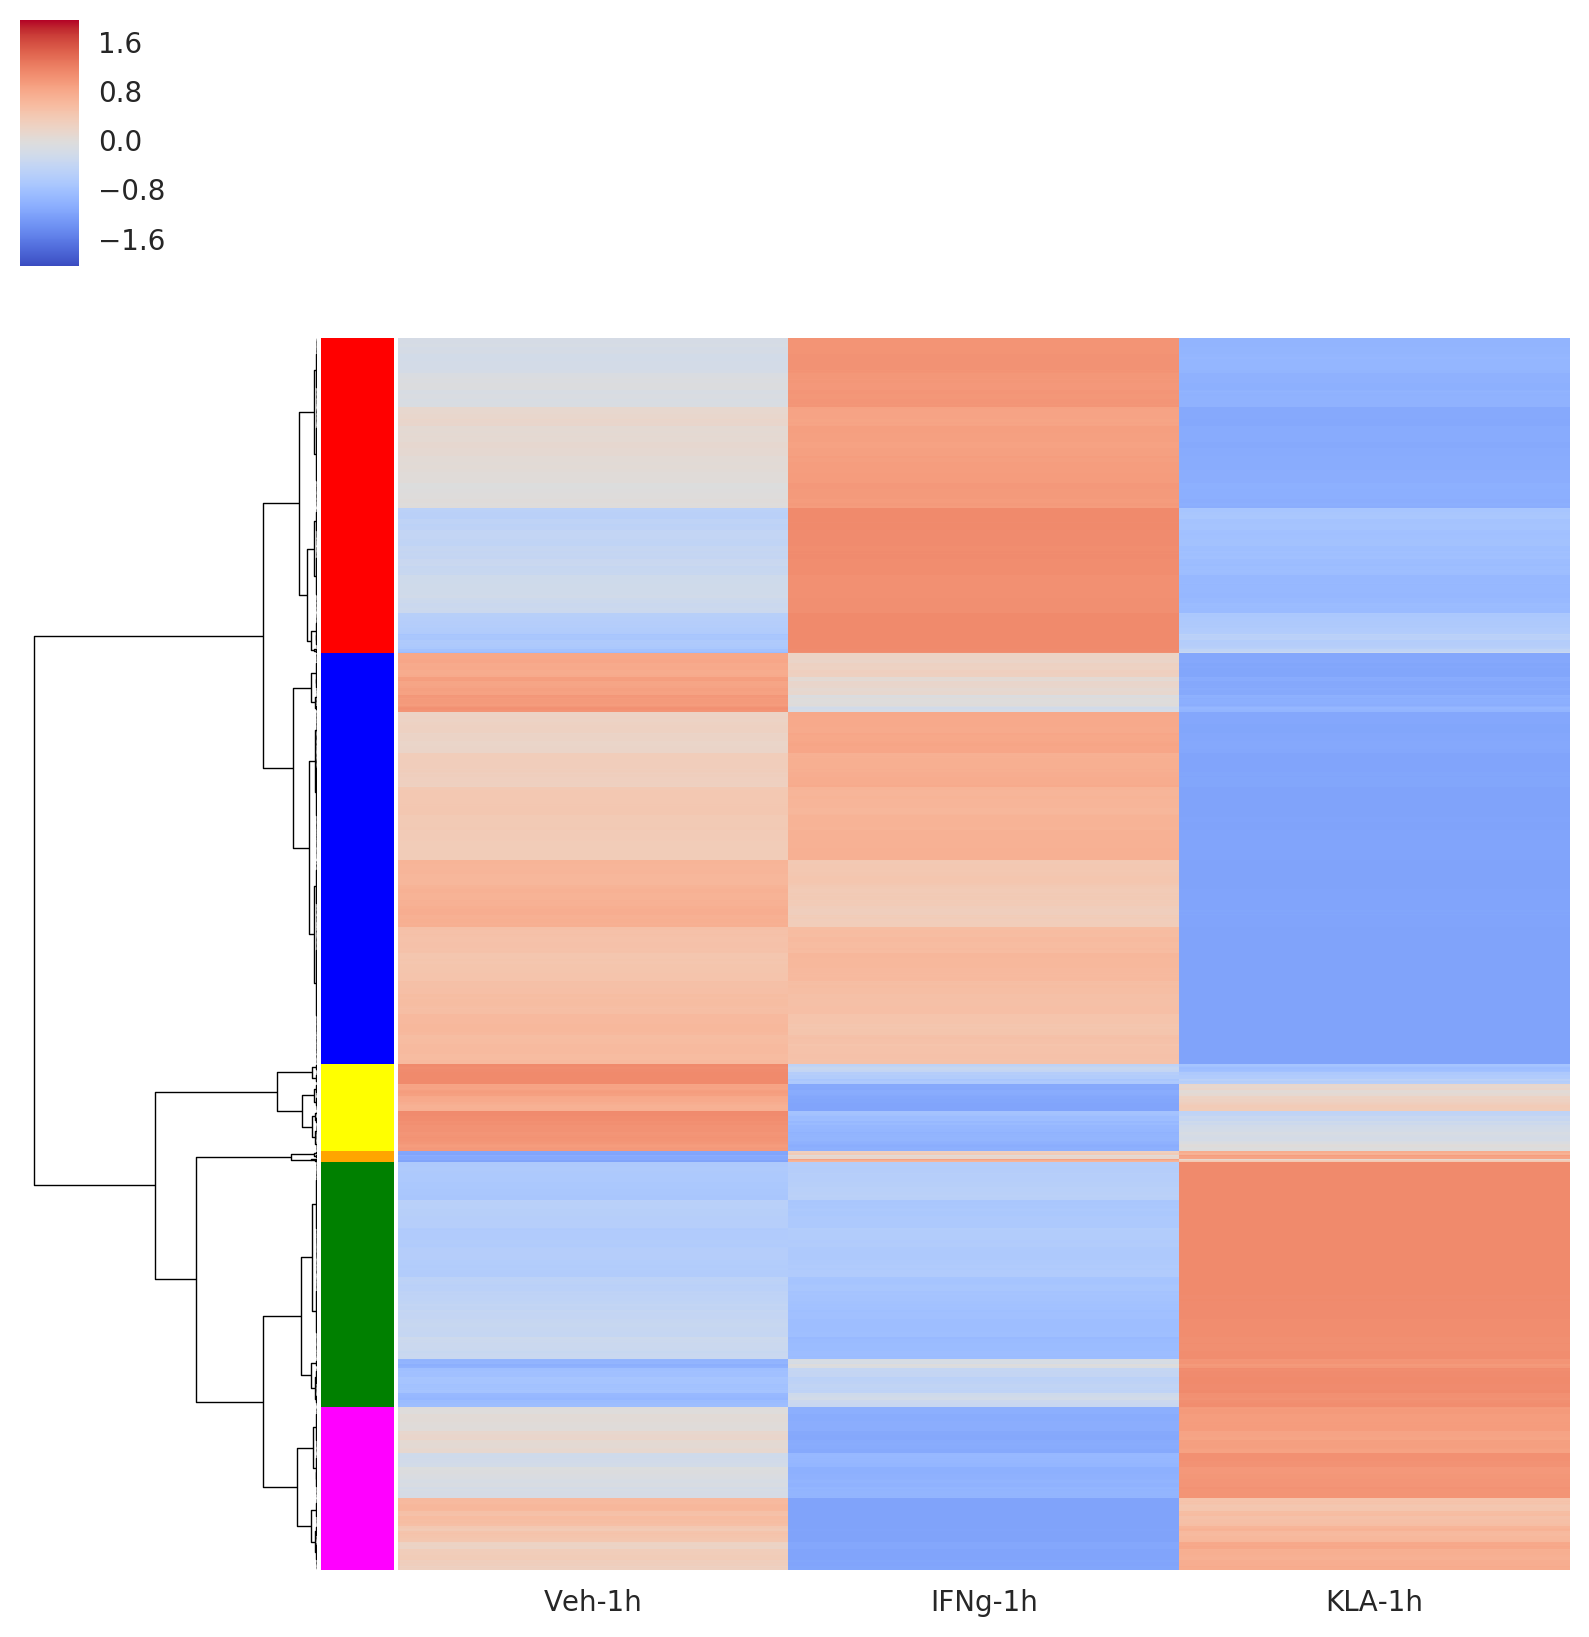

In [28]:
numRowClusters = 6
colorDict = dict(zip(range(numRowClusters),['red', 'blue', 'yellow', 'orange', 'green', 'magenta', 'grey']))

data = rpkm_mean_frame[(rpkm_mean_frame['Gene'].isin(diff_expressed_genes)) &
                (rpkm_mean_frame.ix[:,['Veh-1h', 'IFNg-1h', 'KLA-1h']].max(axis=1) >= 16)].ix[:,['Veh-1h', 'IFNg-1h', 'KLA-1h']]


cg=sns.clustermap(data,
               yticklabels=False,
               col_cluster=False,
               row_cluster=True,
               vmin=-2,
               vmax=2,
               cmap='coolwarm',
               z_score = 0,
               metric = 'correlation',
               method='centroid'
                  
              )
plt.close()
row_linkage = cg.dendrogram_row.linkage

row_flatCluster = scipy.cluster.hierarchy.fcluster(row_linkage, numRowClusters, criterion="maxclust")

row_colors = [colorDict[row_flatCluster[i] -1] for i in range(len(data.index))]
sns.clustermap(data, 
                row_linkage = row_linkage,
                row_colors = row_colors,
                yticklabels = False,
                col_cluster=False,
                vmin=-2,
                vmax=2,
                cmap='coolwarm',
               z_score = 0,
)

print(data.shape)

In [29]:
# ['red', 'blue', 'yellow', 'orange', 'green', 'magenta']
cluster_name_dict = {1:'IFNg Specific',2:'IFNg Specific',3:'KLA Down',4:'Veh Specific', 5:'IFNg Down', 6:'KLA Specific'}

In [30]:
gene_cluster_dict = dict(zip(data.index.values, row_flatCluster))
cluster_genes_dict = {x:[] for x in range(1,numRowClusters+1)}
for gene in gene_cluster_dict:
    cluster = gene_cluster_dict[gene] 
    cluster_genes_dict[cluster].append(gene)

In [31]:
id_sequence_array_dict = dict(zip(id_list, sequence_array_list))

In [32]:
cluster_promoterID_dict = {}
promoterID_cluster_dict = {}
for cluster in cluster_genes_dict:
    cluster_genes = cluster_genes_dict[cluster]
    cluster_seq_ids = []
    
    for g in cluster_genes:
        if g in gene_id_dict:
            promoter_id = gene_id_dict[g]
            cluster_seq_ids.append(promoter_id)
            promoterID_cluster_dict[promoter_id] = cluster
    if len(cluster_seq_ids) > 50:
        cluster_promoterID_dict[cluster] = cluster_seq_ids
        print(cluster)
        print(len(cluster_genes), len(set(cluster_genes)))
        print(len(cluster_seq_ids), len(set(cluster_seq_ids)))



1
510 510
419 419
2
665 665
536 536
3
142 142
120 120
5
397 397
318 318
6
264 264
221 221


## Visualize Differential ATAC Peaks

In [33]:
diff_atac_frame = pd.read_csv('./edgeR_atac_out.tsv', sep='\t')
columns = diff_atac_frame.columns.values
columns[0] = 'PeakID'
diff_atac_frame.columns = columns
diff_atac_frame.index = diff_atac_frame['Chr'] + ':' + (diff_atac_frame['Start'] -1).astype(str) + '-' + diff_atac_frame['End'].astype(str)


diff_atac_frame = diff_atac_frame.ix[:,['PeakID', 'Chr', 'Start', 'End'] + [x for x in diff_atac_frame.columns if 'vs.' in x]]

columns = diff_atac_frame.columns.values
columns = [x.lower() for x in columns]
diff_atac_frame.columns = columns

In [34]:
diff_bound_peaks = diff_atac_frame[
                                     (diff_atac_frame['veh vs. ifng-1h adj. p-value'] < 0.05) |
                                     (diff_atac_frame['veh vs. kla-1h adj. p-value'] < 0.05) |
                                     (diff_atac_frame['ifng-1h vs. kla-1h adj. p-value'] < 0.05)
                                    ].index.values



# diff_bound_peaks = diff_atac_frame[diff_atac_frame[
#         [x for x in diff_atac_frame.columns if 'adj. p-value' in x]].min(axis=1) < 0.05
#                                             ].index.values

(13957, 3)


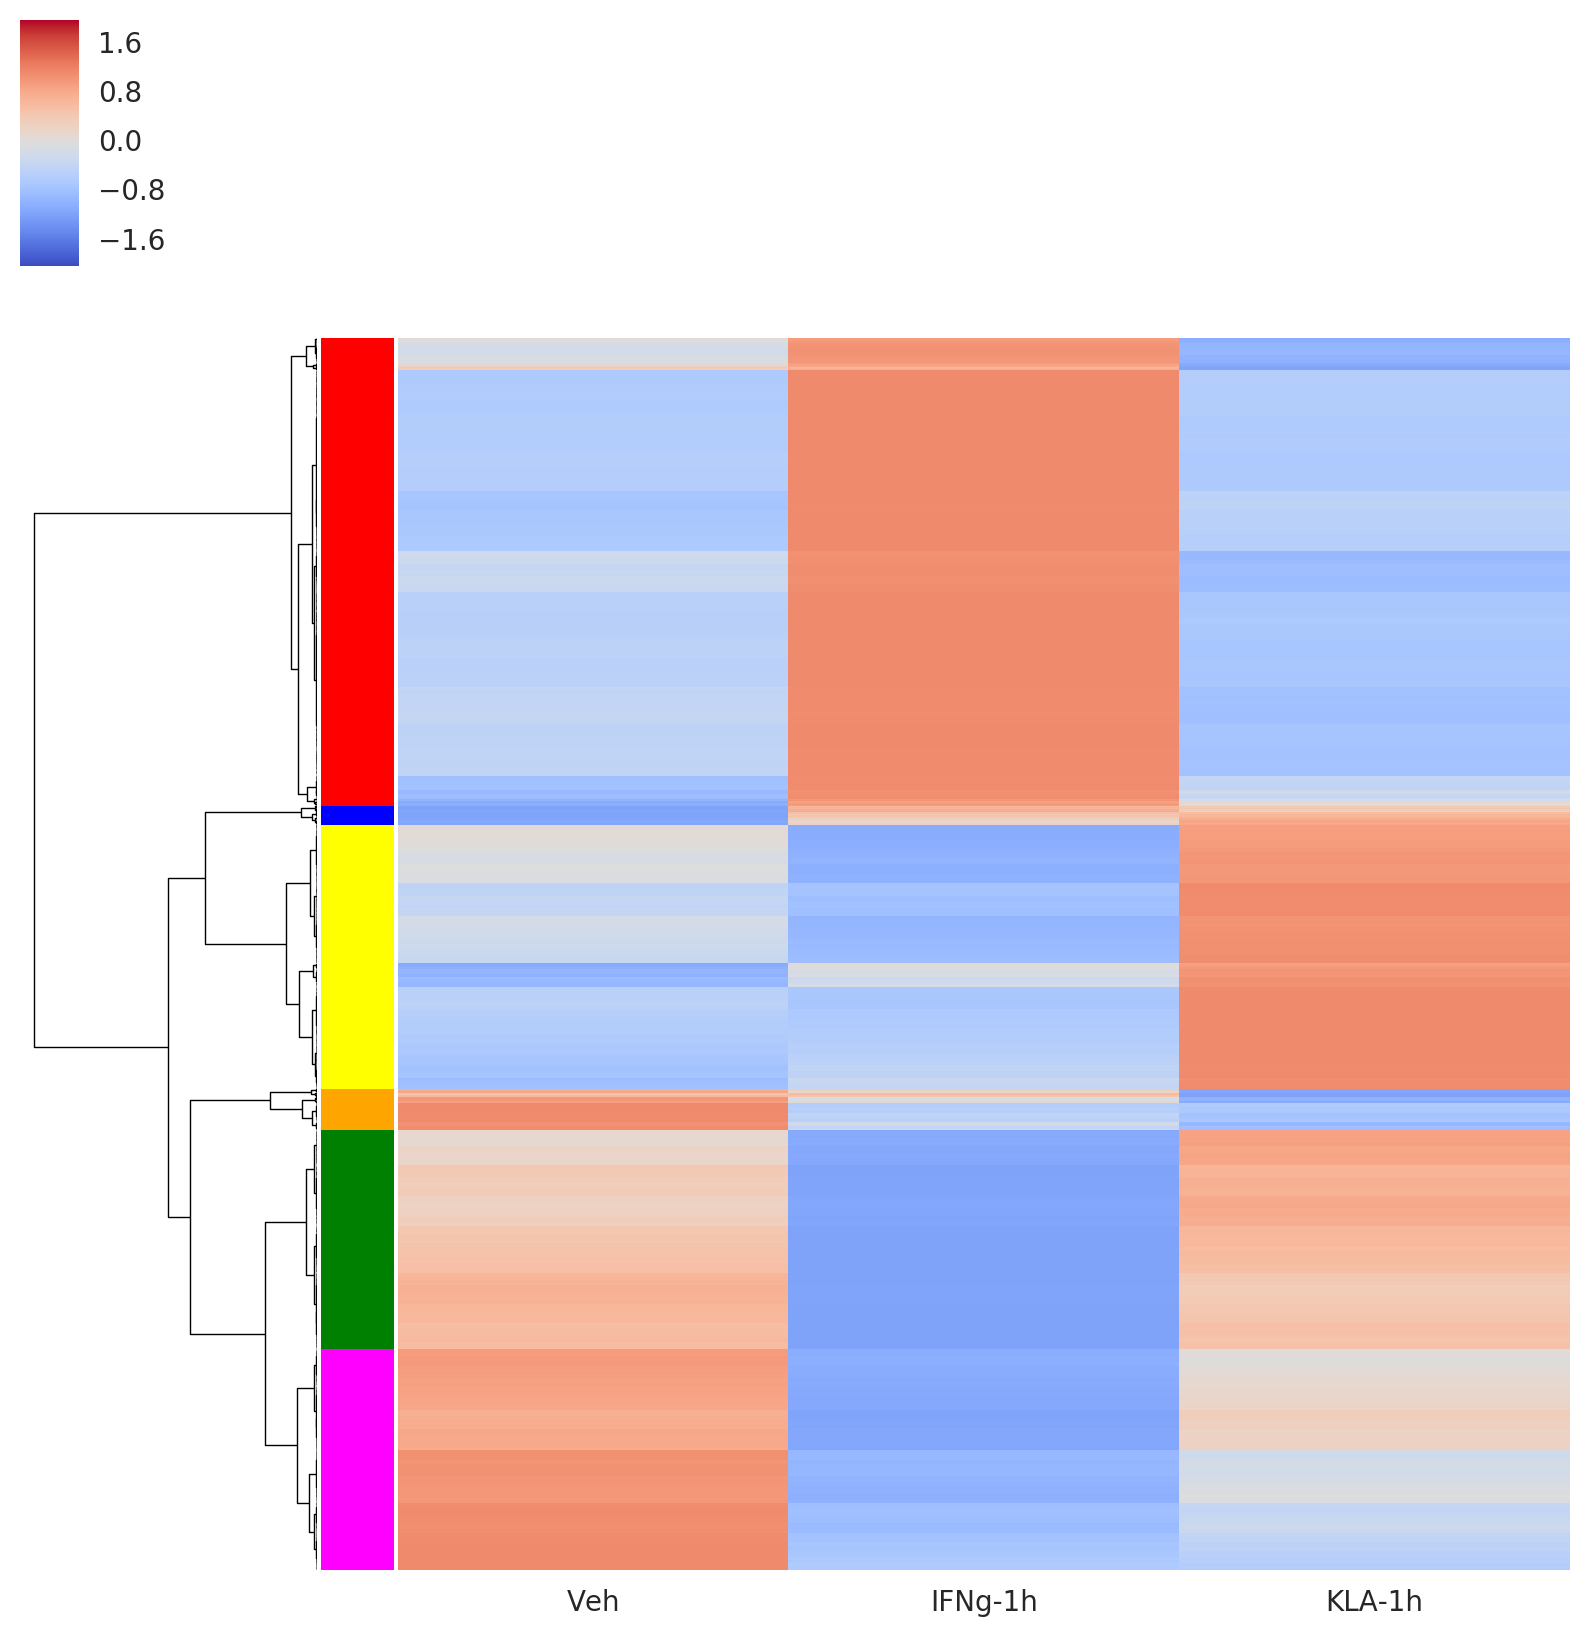

In [35]:
numRowClusters = 6
colorDict = dict(zip(range(numRowClusters),['red', 'blue', 'yellow', 'orange', 'green', 'magenta', 'grey']))
promoter_ids = annotated_frame[annotated_frame['Annotation'].str.contains('promoter')].index.values
data = annotated_mean_frame[(annotated_mean_frame.index.isin(diff_bound_peaks)) &
                            (annotated_mean_frame.ix[:,['Veh', 'IFNg-1h', 'KLA-1h']].max(axis=1) >= 16) &
                            (~annotated_mean_frame.index.isin(promoter_ids))
                           ].ix[:,['Veh', 'IFNg-1h', 'KLA-1h']]


cg=sns.clustermap(data,
               yticklabels=False,
               col_cluster=False,
               row_cluster=True,
               vmin=-2,
               vmax=2,
               cmap='coolwarm',
               z_score = 0,
               metric = 'correlation',
               method='centroid'
                  
              )
plt.close()
row_linkage = cg.dendrogram_row.linkage

row_flatCluster = scipy.cluster.hierarchy.fcluster(row_linkage, numRowClusters, criterion="maxclust")

row_colors = [colorDict[row_flatCluster[i] -1] for i in range(len(data.index))]
sns.clustermap(data, 
                row_linkage = row_linkage,
                row_colors = row_colors,
                yticklabels = False,
                col_cluster=False,
                vmin=-2,
                vmax=2,
                cmap='coolwarm',
               z_score = 0,
)

print(data.shape)

In [36]:
enhancerID_cluster_dict = dict(zip(data.index.values, row_flatCluster))
cluster_enhancerID_dict = {x:[] for x in range(1,numRowClusters+1)}
for eid in enhancerID_cluster_dict:
    ec = enhancerID_cluster_dict[eid]
    cluster_enhancerID_dict[ec].append(eid)



## Loci Overview

#### Promoters

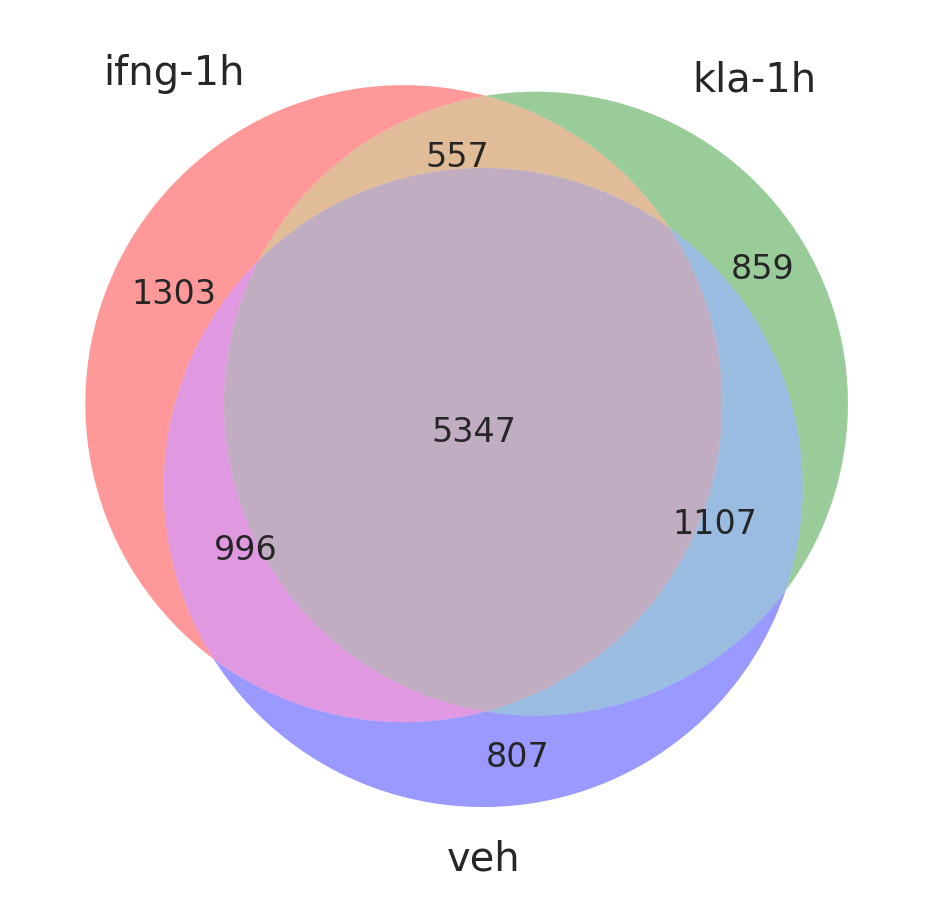

In [40]:
# treatments = summary_frame.columns[5:]
promoter_ids = annotated_frame[annotated_frame['Annotation'].str.contains('promoter')].index.values
treatments = ['ifng-1h', 'kla-1h', 'veh']
id_set_list = []
labels = []
for t in treatments:
    id_set_list.append(set(summary_frame[(summary_frame[t] > 0) &
                                         (summary_frame.index.isin(promoter_ids))].index.values))
    labels.append(t)
matplotlib_venn.venn3(id_set_list, labels)

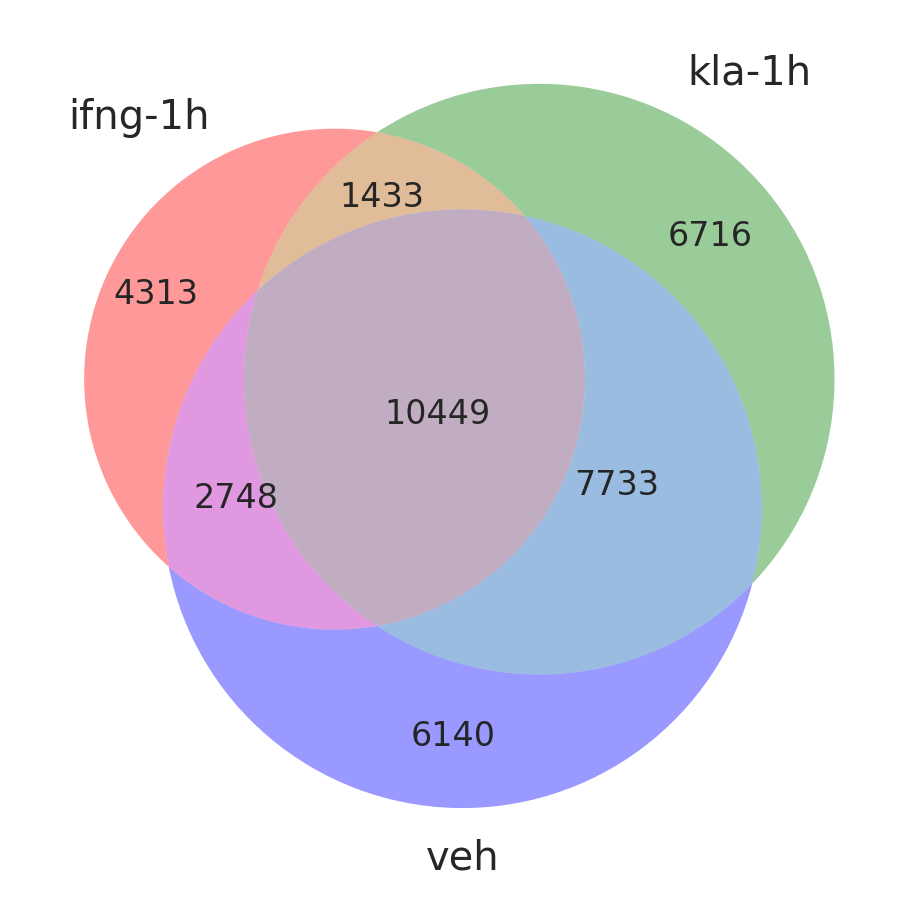

In [42]:
# treatments = summary_frame.columns[5:]
promoter_ids = annotated_frame[annotated_frame['Annotation'].str.contains('promoter')].index.values
treatments = ['ifng-1h', 'kla-1h', 'veh']

id_set_list = []
labels = []
for t in treatments:
    id_set_list.append(set(summary_frame[(summary_frame[t] > 0) &
                                         (~summary_frame.index.isin(promoter_ids))].index.values))
    labels.append(t)
matplotlib_venn.venn3(id_set_list, labels)

## Best Motif Sequence 

In [ ]:
id_motif_sequence_dict = {}
for seq_index in range(len(sequence_array_list)):
    
    msl = calc_motif_sequence(seq_index,
                        sequence_array_list, 
                        motif_score_dict, 
                        motif_score_rc_dict, 
                        motif_size_dict,
                        threshold = 0,
                        symmetric_motifs = symmetric_motifs,
                       )
    seq_id = id_list[seq_index]
    id_motif_sequence_dict[seq_id] = msl
    if seq_index % 100 == 0:
        print(seq_index)

In [ ]:
pickle.dump(id_motif_sequence_dict, open('./id_motif_sequence_dict.pickle', 'wb'))

In [ ]:
id_motif_sequence_dict = pickle.load(open('./id_motif_sequence_dict.pickle', 'rb'))

### Motif K-mers

In [ ]:
k = 3
frequency_list = []
cluster_list = []
kmer_list = []

for key in cluster_promoterID_dict:
    cluster_ids = cluster_promoterID_dict[key]
    motif_sequence_list = [id_motif_sequence_dict[x] for x in cluster_ids ]
    kmer_count_dict = {}
    for msl in motif_sequence_list:
        for i in range(0, len(msl) - k + 1):
            kmer = msl[i:i+k]
            kmer_token = ' * '.join([m['name'] + ' ' + m['orientation'] for m in kmer])
            if kmer_token in kmer_count_dict:
                kmer_count_dict[kmer_token] +=1
            else:
                kmer_count_dict[kmer_token] = 1
    kmer_count_list = [(x,kmer_count_dict[x]) for x in kmer_count_dict]
    
    num_seqs = len(motif_sequence_list)
    frequencies = [x[1]/num_seqs for x in kmer_count_list]
    names = [x[0] for x in kmer_count_list]
    
    kmer_list = kmer_list + names
    cluster_list = cluster_list + [key] * len(frequencies)
    frequency_list = frequency_list + frequencies
            

In [ ]:
frame = pd.DataFrame({'K-mer':kmer_list,
                      'Cluster':cluster_list,
                      'Frequency':frequency_list})

In [ ]:
frame.sort('Frequency', ascending=False, inplace = True)
num_kmers_to_show = 50
kmers_to_show = set()
ordered_kmers = frame['K-mer'].values
counter = 0
while len(kmers_to_show) < num_kmers_to_show and counter < len(ordered_kmers):
    candidate = ordered_kmers[counter]
#     if 'ap-1' in candidate and 'cebp' in candidate:
    kmers_to_show.add(ordered_kmers[counter])
    counter +=1

In [ ]:
sns.factorplot(data = frame[frame['K-mer'].isin(kmers_to_show)],
               x='K-mer',
               y = 'Frequency',
               hue = 'Cluster',
               kind='bar',
               hue_order=[1,2,3,4],
               size=8)
plt.xticks(rotation = 90);

In [ ]:
sns.distplot(frame['Frequency'])
plt.xlabel('Fraction of Promoters in Cluster that Contains Motif K-mer')
plt.ylabel('# Motif K-mer')

## Motif skip-mers

In [ ]:
k = 3
frequency_list = []
cluster_list = []
kmer_list = []
for key in cluster_promoterID_dict:
    print('cluster', key)
    cluster_ids = cluster_promoterID_dict[key]
    motif_sequence_list = [id_motif_sequence_dict[x] for x in cluster_ids ]
    kmer_count_dict = {}
    counter = 0
    for msl in motif_sequence_list:
        for x in range(0,len(msl) - 2):
            for y in range(x+1, len(msl) - 1):
                for z in range(y+1, len(msl)):
                    kmer = [msl[x], msl[y], msl[z]]
                    kmer_token = ' * '.join([m['name'] + ' ' + m['orientation'] for m in kmer])
                    if kmer_token in kmer_count_dict:
                        kmer_count_dict[kmer_token] +=1
                    else:
                        kmer_count_dict[kmer_token] = 1
        counter+=1
        if counter %100 ==0:
            print(counter)
    kmer_count_list = [(x,kmer_count_dict[x]) for x in kmer_count_dict]
    
    num_seqs = len(motif_sequence_list)
    frequencies = [x[1]/num_seqs for x in kmer_count_list]
    names = [x[0] for x in kmer_count_list]
    
    kmer_list = kmer_list + names
    cluster_list = cluster_list + [key] * len(frequencies)
    frequency_list = frequency_list + frequencies
cluster_name_list = [cluster_name_dict[x] for x in cluster_list]

            

In [ ]:
frame = pd.DataFrame({'K-mer':kmer_list,
                      'Cluster':cluster_list,
                      'Frequency':frequency_list,
                      'Cluster Name':cluster_name_list})

In [ ]:
frame.sort('Frequency', ascending=False, inplace = True)
num_kmers_to_show = 50
kmers_to_show = set()
ordered_kmers = frame['K-mer'].values
counter = 0
while len(kmers_to_show) < num_kmers_to_show and counter < len(ordered_kmers):
    candidate = ordered_kmers[counter]
    if not 'mzf1' in candidate and not 'nfi' in candidate:
        kmers_to_show.add(ordered_kmers[counter])
    counter +=1

In [ ]:
sns.factorplot(data = frame[frame['K-mer'].isin(kmers_to_show)],
               x='K-mer',
               y = 'Frequency',
               hue = 'Cluster Name',
               kind='bar',
#                hue_order=[1,2,3,4],
               size=8)
plt.xticks(rotation = 90);

In [ ]:
sns.distplot(frame['Frequency'])
plt.xlabel('Fraction of Promoters in Cluster that Contains Motif K-mer')
plt.ylabel('# Motif K-mer')

In [ ]:
_=plot_motif_sequence(100,
                        sequence_array_list, 
                        motif_score_dict, 
                        motif_score_rc_dict, 
                        motif_size_dict,
                        threshold = 0,
                        color_dict = None,
                        symmetric_motifs = symmetric_motifs,
                        algorithm_plot = False,
                       )

## Identify Expressed TFs and Motifs

#### Read in motif gene mapping

In [ ]:
gene_motif_dict = {}
with open('/gpfs/data01/glasslab/home/jtao/analysis/jaspar_analysis/clustered_motifs/motifGene.txt') as f:
    data = f.readlines()
for line in data:
    tokens = line.strip().split()
    motif = tokens[0]
    genes = tokens[1].split('|')
    if motif in motif_size_dict:
        for g in genes:
            if g in gene_motif_dict:
                gene_motif_dict[g.upper()].append(motif)
            else:
                gene_motif_dict[g.upper()] = [motif]

### Plot # of motifs vs expression threshold

In [ ]:
expression_threshold = 16
# thresholds = [1,2,4,8,16,32,64,128]
thresholds = range(100)
num_motifs = []
for expression_threshold in thresholds:
    motifs_at_threshold = []
    gene_names = rpkm_mean_frame[
        rpkm_mean_frame.ix[:,2:].max(axis=1) >= expression_threshold
                    ].ix[:,'All Gene Names'].values
    for gn in gene_names:
        genes = gn.upper().split('|')
        for g in genes:
            if g in gene_motif_dict:
                motifs_at_threshold += gene_motif_dict[g]
    motifs_at_threshold = sorted(set(motifs_at_threshold))
    num_motifs.append(len(motifs_at_threshold))
plt.plot(thresholds, num_motifs) 
plt.xlabel('Expression Threshold (RPKM)')
plt.ylabel('Number of Motifs')

In [ ]:
expression_threshold = 20
motifs_to_include = []
gene_names = rpkm_mean_frame[
    rpkm_mean_frame.ix[:,2:].max(axis=1) >= expression_threshold
                ].ix[:,'All Gene Names'].values
for gn in gene_names:
    genes = gn.upper().split('|')
    for g in genes:
        if g in gene_motif_dict:
            motifs_to_include += gene_motif_dict[g]
motifs_to_include = sorted(set(motifs_to_include))
print(len(set(motifs_to_include)))

In [ ]:
for m in motifs_to_include:
    print(m)

## Find Enriched Motifs with Top Motif Score

### Promoters

In [ ]:
# treatments = summary_frame.columns[5:]
promoter_ids = annotated_frame[annotated_frame['Annotation'].str.contains('promoter')].index.values
treatments = ['ifng-1h', 'kla-1h', 'veh']
# motifs = sorted(topMotifScore_frame.columns.values)
motifs = motifs_to_include
threshold = 0.05

treatment_enrichedMotif_promoter_dict = {}
for t in treatments:
    treatment_enrichedMotif_promoter_dict[t] = []
    treatment_indices = summary_frame[(summary_frame[t] > 0) &
                                      (summary_frame.index.isin(promoter_ids))].index.values
    other_indices = summary_frame[(summary_frame[t] == 0) &
                                  (summary_frame.index.isin(promoter_ids))].index.values
    for m in motifs:
        treatment_scores = topMotifScore_frame.ix[treatment_indices, m].values
        other_scores = topMotifScore_frame.ix[other_indices, m].values
        is_enriched = np.mean(treatment_scores) > np.mean(other_scores)
        stat, pval = scipy.stats.ttest_ind(treatment_scores, other_scores)
        if pval < threshold/len(motifs) and is_enriched:
            treatment_enrichedMotif_promoter_dict[t].append(m)
            print(t, m,pval)
            


### Enhancers

In [ ]:
# treatments = summary_frame.columns[5:]
promoter_ids = annotated_frame[annotated_frame['Annotation'].str.contains('promoter')].index.values
treatments = ['ifng-1h', 'kla-1h', 'veh']
# motifs = sorted(topMotifScore_frame.columns.values)
motifs = motifs_to_include
threshold = 0.05

treatment_enrichedMotif_enhancer_dict = {}
for t in treatments:
    treatment_enrichedMotif_enhancer_dict[t] = []
    treatment_indices = summary_frame[(summary_frame[t] > 0) &
                                      (~summary_frame.index.isin(promoter_ids))].index.values
    other_indices = summary_frame[(summary_frame[t] == 0) &
                                  (~summary_frame.index.isin(promoter_ids))].index.values
    for m in motifs:
        treatment_scores = topMotifScore_frame.ix[treatment_indices, m].values
        other_scores = topMotifScore_frame.ix[other_indices, m].values
        is_enriched = np.mean(treatment_scores) > np.mean(other_scores)
        stat, pval = scipy.stats.ttest_ind(treatment_scores, other_scores)
        if pval < threshold/len(motifs) and is_enriched:
            treatment_enrichedMotif_enhancer_dict[t].append(m)
            print(t, m,pval)
            if treatment == 'kla-1h' and m =='Jun-related_1_merged':
#                 sns.distplot(treatment_scores, label='KLA')
#                 sns.distplot(other_scores, label = 'Other')
                plt.boxplot([treatment_scores+0.5, other_scores])
                plt.ylabel('Motif Score')
                plt.xticks(range(1,3),['KLA', 'Other'])
#                 plt.legend()

In [ ]:
sorted_treatments = sorted(treatment_enrichedMotif_enhancer_dict.keys())

matplotlib_venn.venn3([set(treatment_enrichedMotif_enhancer_dict[x]) for x in sorted_treatments], set_labels=sorted_treatments)

In [ ]:
for treatment in treatment_enrichedMotif_promoter_dict:
    promoter_motifs = set(treatment_enrichedMotif_promoter_dict[treatment])
    enhancer_motifs = set(treatment_enrichedMotif_enhancer_dict[treatment])
    matplotlib_venn.venn2([promoter_motifs, enhancer_motifs], set_labels=['promoter', 'enhancer'])
    plt.title(treatment)
    plt.show()
    print(treatment)
    print('enhancer specific', enhancer_motifs - promoter_motifs)
    print('promoter specific', promoter_motifs - enhancer_motifs)

In [ ]:
treatment_enrichedMotif_enhancer_dict.values()
enhancer_motifs = set()
for t in treatment_enrichedMotif_enhancer_dict:
    enhancer_motifs = enhancer_motifs.union(set(treatment_enrichedMotif_enhancer_dict[t]))
enhancer_motifs = sorted(enhancer_motifs)

### Cluster Promoters On Motif Scores

In [ ]:
promoter_ids = annotated_frame[annotated_frame['Annotation'].str.contains('promoter')].index.values
colorDict = dict(zip(range(numRowClusters),['red', 'blue', 'yellow', 'orange', 'green', 'magenta', 'grey']))
data = topMotifScore_frame.ix[sorted(promoterID_cluster_dict.keys()), enhancer_motifs]
row_colors = [colorDict[promoterID_cluster_dict[i] -1] for i in data.index.values]
sns.clustermap(data,
               z_score=0,
               yticklabels=False,
               metric = 'correlation',
               method = 'centroid',
               vmin = -2,
               vmax = 2,
               row_colors= row_colors
              )

### Cluster Enhancers on Motif Scores

In [ ]:
promoter_ids = annotated_frame[annotated_frame['Annotation'].str.contains('promoter')].index.values
data = topMotifScore_frame.ix[topMotifScore_frame.index.isin(enhancerID_cluster_dict), enhancer_motifs]
row_colors = [colorDict[enhancerID_cluster_dict[i] -1] for i in data.index.values]
sns.clustermap(data,
               z_score=0,
               yticklabels=False,
               metric = 'correlation',
               method = 'centroid',
               row_colors = row_colors,
               vmin = -2,
               vmax = 2,
              )


# New Motif Sequence Algorithm

### Refactor motif_score_dict

In [ ]:
id_motifScore_forward_dict = {}
for i in range(len(id_list)):
    current_id = id_list[i]
    current_dict = {}
    for motif in motifs_to_include:
        if motif in motif_score_dict:
            current_dict[motif] = motif_score_dict[motif][i]
    id_motifScore_forward_dict[current_id] = current_dict

In [ ]:
id_motifScore_reverse_dict = {}
for i in range(len(id_list)):
    current_id = id_list[i]
    current_dict = {}
    for motif in motifs_to_include:
        if motif in motif_score_rc_dict:
            current_dict[motif] = motif_score_rc_dict[motif][i]
    id_motifScore_reverse_dict[current_id] = current_dict

In [ ]:
def calc_multi_motif_sequence(seq_array, 
                              forward_score_dict, 
                              reverse_score_dict, 
                              motif_size_dict,
                              score_threshold = 0,
                              distance_threshold = 200,
                              symmetric_motifs = []
                             ):
    '''
    '''
    motif_names = sorted(forward_score_dict.keys())
    seq_size = seq_array.shape[0]
    # initialize position_node array
    position_node_array = [[] for x in range(seq_size)]

    # intialize graph
    seq_graph = nx.DiGraph()

    # initialize
    for motif in motif_names:
        motif_size = motif_size_dict[motif]
        indices = list(range(len(forward_score_dict[motif])))
        forward_scores = forward_score_dict[motif]
        revcomp_scores = reverse_score_dict[motif]

        # identify motif instances using score score_threshold
        filtered_forward_motif_instances = [x for x in zip(indices, forward_scores) if x[1]>score_threshold]
        filtered_revcomp_motif_instances = [x for x in zip(indices, revcomp_scores) if x[1]>score_threshold]

        # create graph node for every forward motif instance
        for mi in filtered_forward_motif_instances:
            node_id = str(mi[0]) + ' ' + motif + ' +'
            seq_graph.add_node(node_id, 
                               name=motif,
                               start=mi[0], 
                               end = mi[0] + motif_size, 
                               score=mi[1], 
                               orientation='+')

            # figure out positions motif instance occupies
            start_position = mi[0]
            end_position=start_position + motif_size

            # add node_id to position_node array
            for pos in range(start_position, end_position):
                position_node_array[pos].append(node_id)

        # create graph node for every revcomp motif instance
        for mi in filtered_revcomp_motif_instances:
            node_id = str(mi[0]) + ' ' + motif + ' -'
            seq_graph.add_node(node_id, 
                               name=motif,
                               start=mi[0], 
                               end = mi[0] + motif_size, 
                               score=mi[1], 
                               orientation='-')

            # figure out positions motif instance occupies
            start_position = mi[0]
            end_position=start_position + motif_size

            # add node_id to position_node array
            for pos in range(start_position, end_position):
                position_node_array[pos].append(node_id)

    # add edges
    all_nodes = seq_graph.nodes(data=True)
    edges_to_add = []
    for node in all_nodes:
        # find the first nonoverlapping motif(s)
        end_pos = node[1]['end']
        first_neighbor_pos = end_pos
        candidate_neighbors = []
        while len(candidate_neighbors) < 1 and first_neighbor_pos < seq_size:
            candidate_neighbors = position_node_array[first_neighbor_pos]
            first_neighbor_pos += 1
            
        # find largest motif amongst the first nonoverlapping motif(s)
        max_size_end = -1
        max_size_start = -1
        for n in candidate_neighbors:
            neighbor = seq_graph.node[n]
            neighbor_end = neighbor['end']
            neighbor_start = neighbor['start']
            if neighbor_end > max_size_end:
                max_size_end = neighbor_end
                max_size_start = neighbor_start
        # identify all motifs that overlap with the first largest nonoverlapping motif(s)
        for pos in range(max_size_start, max_size_end):
            candidate_neighbors = candidate_neighbors + position_node_array[pos]
        candidate_neighbors = set(candidate_neighbors)
        
        for n in candidate_neighbors:
            neighbor = seq_graph.node[n]
            neighbor_start = neighbor['start']
            if neighbor_start >= end_pos:
                edges_to_add.append((node[0], n))
    seq_graph.add_edges_from(edges_to_add)

    # creat start node and connect all nodes with 0 incoming edges
    start_edges = []
    for node_id, in_degree in seq_graph.in_degree_iter():
        if in_degree == 0:
            start_edges.append(('start', node_id))
            
    # create end node and connect all nodes with 0 outgoing edges
    end_edges = []
    for node_id, out_degree in seq_graph.out_degree_iter():
        if out_degree == 0:
            end_edges.append((node_id, 'end'))
    
    seq_graph.add_edges_from(start_edges)
    seq_graph.add_edges_from(end_edges)
    
    # generate all paths from start to end node
    paths = nx.all_simple_paths(seq_graph, 'start', 'end')
    
    # add data to list of paths
    id_score_dict = nx.get_node_attributes(seq_graph, 'score')
    paths_with_data = []
    paths_without_data = []
    counter = 0
    for p in paths:
        
        if counter > 1000:
            print('Too many paths!!!')
            return seq_graph, [], [] 
        counter += 1
        
        current_p_with_data = []
        current_p_without_data = []
        for n in p:
#             if n == 'start':
#                 motif_name = 'start'
#                 orientation = '|'
#                 score = score_threshold
#             elif n == 'end':
#                 motif_name = 'end'
#                 orientation = '|'
#                 score = score_threshold
#             else:
            # exclude end and start nodes which were created just for creating paths
            if not n== 'start' and not n == 'end':
                tokens = n.split()
                motif_name = tokens[1]
                orientation = tokens[2]
                score = id_score_dict[n]
                
                n_with_data = (motif_name, orientation, score)
                current_p_with_data.append(n_with_data)
                current_p_without_data.append(motif_name + ' ' + orientation)
        paths_with_data.append(current_p_with_data)
        paths_without_data.append(current_p_without_data)

    return seq_graph, paths_with_data, paths_without_data

In [ ]:
index = 1
seq_array = sequence_array_list[index]
forward_score_dict = id_motifScore_forward_dict[id_list[index]]
reverse_score_dict = id_motifScore_reverse_dict[id_list[index]]
graph, paths, paths_nodata = calc_multi_motif_sequence(seq_array, 
                              forward_score_dict, 
                              reverse_score_dict, 
                              motif_size_dict,
                              score_threshold = 5,
                              distance_threshold = 200,
                              symmetric_motifs = symmetric_motifs
                             )
print(nx.info(graph))

In [ ]:
nx.draw(graph,
        node_size=50,
        with_labels=True,
        font_size = 8,
        pos=graphviz_layout(graph, prog = 'dot'))


## Calculate motif paths for sequences

### Promoters

In [ ]:
clustered_promoterIDs = list(promoterID_cluster_dict.keys())

id_pathList_promoter_dict = {}
counter = 0
for index in range(len(clustered_promoterIDs)):
    if index % 100 ==0: 
        print(index)
    seq_id = clustered_promoterIDs[index]
    seq_array = sequence_array_list[index]
    forward_score_dict = id_motifScore_forward_dict[seq_id]
    reverse_score_dict = id_motifScore_reverse_dict[seq_id]
    result = calc_multi_motif_sequence(seq_array, 
             forward_score_dict, 
             reverse_score_dict, 
             motif_size_dict,
             score_threshold = 5,
             distance_threshold = 200,
             symmetric_motifs = symmetric_motifs
             )
    graph, paths_with_data, paths_without_data = result
    if len(paths_without_data) > 1:
        id_pathList_promoter_dict[seq_id] = paths_without_data
    else:
        counter +=1
print(counter)

In [ ]:
num_paths = []
for seq_id in id_pathList_promoter_dict:
    paths = id_pathList_promoter_dict[seq_id]
    num_paths.append(len(paths))
    if len(paths) < 5:
        print(seq_id)
sns.distplot([np.log2(x) for x in num_paths])
plt.ylabel('Frequency (KDE)')
plt.xlabel('Number of Motif Sequences (log2)')

### Enhancers

In [ ]:
clustered_enhancerIDs = list(enhancerID_cluster_dict.keys())

id_pathList_enhancer_dict = {}
counter = 0
for index in range(len(clustered_enhancerIDs)):
    if index % 100 ==0: 
        print(index)
    seq_id = clustered_enhancerIDs[index]
    seq_array = sequence_array_list[index]
    forward_score_dict = id_motifScore_forward_dict[seq_id]
    reverse_score_dict = id_motifScore_reverse_dict[seq_id]
    result = calc_multi_motif_sequence(seq_array, 
             forward_score_dict, 
             reverse_score_dict, 
             motif_size_dict,
             score_threshold = 5,
             distance_threshold = 200,
             symmetric_motifs = symmetric_motifs
             )
    graph, paths_with_data, paths_without_data = result
    if len(paths_without_data) > 1:
        id_pathList_enhancer_dict[seq_id] = paths_without_data
    else:
        counter +=1
print(counter)

In [ ]:
num_paths = []
for seq_id in id_pathList_enhancer_dict:
    paths = id_pathList_enhancer_dict[seq_id]
    num_paths.append(len(paths))
    if len(paths) < 5:
        print(seq_id)
sns.distplot([np.log2(x) for x in num_paths])
plt.ylabel('Frequency (KDE)')
plt.xlabel('Number of Motif Sequences (log2)')

## Pattern Finding Algorithm

### Promoter

In [ ]:
min_support_level = 25

frequent_promoter_patterns = motif_prefix_span([], id_pathList_promoter_dict, min_support_level)


In [ ]:
path_lengths = []
for seq_id in id_pathList_promoter_dict:
    paths = id_pathList_promoter_dict[seq_id]
    for p in paths:
        path_lengths.append(len(p))


In [ ]:
plt.hist(path_lengths);
plt.xlabel('Length of Motif Path')
plt.ylabel('Frequency')

In [ ]:
sequence_pattern_promoter_table = create_pattern_sequence_table(frequent_promoter_patterns, id_pathList_promoter_dict)

In [ ]:
sequence_pattern_promoter_table.to_picke('./sequence_pattern_promoter_table.pickle')

In [ ]:
sns.distplot(sequence_pattern_promoter_table.sum())
plt.xlabel('Frequency of Pattern')
plt.ylabel('Frequency (KDE)')

### Enhancer

In [ ]:
def motif_prefix_span(prefix, database, support_level):
    '''
    Finds frequents sequences of motifs in a datase of sequences and their corresponding
    motif paths
    inputs: prefix - a string representing a motif and its orientation
            database - a dictionary containing lists of motif paths corresponding to each sequence
            support level - number of times a motif must appear to be counted
    outputs: a list of frequent patterns
    '''
#     print('***', prefix, len(database))
    if len(database) >= support_level:
        frequent_motifs = find_frequent_motifs(database, support_level)
    else:
        frequent_motifs = []
    to_return = []
    if len(frequent_motifs) > 0:
        for fm in frequent_motifs:
            new_pattern = prefix + [fm]
            projected_database = project_database(fm, database)
            
            fm_results = motif_prefix_span(new_pattern, 
                                           projected_database, 
                                           support_level)
            to_return = to_return +  fm_results 
            to_return.append(new_pattern)
            print(new_pattern, len(to_return))

    return to_return

In [ ]:
min_support_level = 500

frequent_enhancer_patterns = motif_prefix_span([], id_pathList_enhancer_dict, min_support_level)


In [ ]:
print(len(frequent_enhancer_patterns))

In [ ]:
pickle.dump(frequent_enhancer_patterns, open('./frequent_enhancer_patterns.pickle','wb'))

In [ ]:
path_lengths = []
for seq_id in id_pathList_enhancer_dict:
    paths = id_pathList_enhancer_dict[seq_id]
    for p in paths:
        path_lengths.append(len(p))


In [ ]:
plt.hist(path_lengths);
plt.xlabel('Length of Motif Path')
plt.ylabel('Frequency')

In [ ]:
# def create_pattern_sequence_table(frequent_patterns, database):
#     '''
#     Constructs a matrix summarizing which sequences contains a frequent motif pattern
#     '''
#     sorted_ids = sorted(database.keys())
#     pattern_names = [' * '.join(x) for x in frequent_patterns]
#     sequence_pattern_table = pd.DataFrame(np.zeros((len(sorted_ids), len(pattern_names))),
#                                           index = sorted_ids,
#                                           columns = pattern_names)
#     for i in range(len(frequent_patterns)):
#         if i % 10 == 0:
#             print(i)
#         pattern = frequent_patterns[i]
#         pattern_name = pattern_names[i]
#         for seq_id in sorted_ids:
#             motif_paths = database[seq_id]
#             has_pattern = False
#             for path in motif_paths:
#                 path_iter = iter(path)
#                 has_pattern = all([m in path_iter for m in pattern])
#                 if has_pattern:
#                     sequence_pattern_table.ix[seq_id, pattern_name] = 1
#     return sequence_pattern_table
            
        

In [ ]:
sequence_pattern_enhancer_table = create_pattern_sequence_table(frequent_enhancer_patterns, id_pathList_enhancer_dict)

In [ ]:
import multiprocessing


In [ ]:
def find_pattern(pattern,
                 sorted_ids,
                 database,
                 result_dict,
                 ):
    pattern_name = ' * '.join(pattern)
    has_pattern_list = []
    for seq_id in sorted_ids:
        motif_paths = database[seq_id]
        has_pattern = False
        for path in motif_paths:
            path_iter = iter(path)
            has_pattern = all([m in path_iter for m in pattern])
            if has_pattern:
                has_pattern_list.append(1)
                break
    result_dict.ix[pattern_name] = has_pattern_list
    print('done searching for', pattern_name)
    return None

In [ ]:
def create_pattern_sequence_table_pooled(frequent_patterns, 
                                         database,
                                         num_procs = 8):
    '''
    Constructs a matrix summarizing which sequences contains a frequent motif pattern
    '''

    pool = multiprocessing.Pool(processes=num_procs)
    manager = multiprocessing.Manager()
    has_pattern_dict= manager.dict() # {pattern:[seq_has_pattern_1, seq_has_pattern_2]}
    
    sorted_ids = sorted(database.keys())   

    for i in range(len(frequent_patterns)):
        pattern = frequent_patterns[i]
        pool.apply_async(find_pattern,
                         args=(pattern,
                               sorted_ids,
                               database,
                               has_pattern_dict,
                               )       
                        )
    pool.close()
    pool.join()
    
    has_pattern_dict = dict(has_pattern_dict)
    sequence_pattern_table = pd.DataFrame(has_pattern_dict,
                                          index = sorted_ids)
    return sequence_pattern_table

In [ ]:
sequence_pattern_enhancer_table = create_pattern_sequence_table_pooled(frequent_enhancer_patterns, 
                                                                       id_pathList_enhancer_dict,
                                                                       num_procs = 28)

In [ ]:
sns.distplot(sequence_pattern_enhancer_table.sum())
plt.xlabel('Frequency of Pattern')
plt.ylabel('Frequency (KDE)')

## Decision Tree

### Promoters

In [ ]:
clf = tree.DecisionTreeClassifier(criterion='gini',
                                 max_depth=5, 
#                                  min_samples_split=50,
#                                  min_samples_leaf=50,
                                 )
labels = [promoterID_cluster_dict[x] for x in sequence_pattern_promoter_table.index.values]


clf.fit(sequence_pattern_promoter_table, 
        labels
        )

clf.score(sequence_pattern_promoter_table, labels)

In [ ]:
tree.export_graphviz(clf, 
                     out_file='tree_promoter.dot',
                     feature_names = sequence_pattern_promoter_table.columns.values)

!dot -Tpng tree_promoter.dot -o tree_promoter.png

### Enhancers

In [ ]:
clf = tree.DecisionTreeClassifier(criterion='entropy',
                                 max_depth=6, 
#                                  min_samples_split=50,
#                                  min_samples_leaf=50,
                                 )
labels = [enhancerID_cluster_dict[x] for x in sequence_pattern_enhancer_table.index.values]


clf.fit(sequence_pattern_enhancer_table, 
        labels
        )



In [ ]:
print(clf.score(sequence_pattern_enhancer_table, labels))

In [ ]:
tree.export_graphviz(clf, 
                     out_file='tree_enhancer.dot',
                     feature_names = sequence_pattern_enhancer_table.columns.values)

!dot -Tpng tree_enhancer.dot -o tree_enhancer.png